In [1]:
#Importo librerías necesarias
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
%matplotlib inline
import os

#Cuestiones previas:
###1. La forma de guardar la información de las masas es la siguiente:
+ Cada una tiene dos componentes: un vector $r$ (que contiene posición en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$) y un vector $v$ (que contiene velocidad en $\hat{\textbf{i}}$ y $\hat{\textbf{j}}$).
+ El array Y contiene la información de **todas** las masas en cuestión. El orden de la información contenida en este array es: [$r_1,v_1,r_2,v_2, \dots ,r_n,v_n$]. Definidos $r$ y $v$ como se explicó en el punto anterior.

###2. Utilizamos la siguiente fórmula para definir la interacción gravitacional (Asumiendo $G = 1$):

$$\\ m_i \dfrac{d^2x}{dt^2} = - \sum_{i \neq j} \dfrac{m_i m_j (x_i - x_j)}{r^3_{ij}}\\$$
$$i = 1, \dots , N$$

###3. Utilizamos el método de Runge-Kutta de orden 4 para resolver las ecuaciones diferenciales de movimiento. Recordando que este se basa en que:

$$\dfrac{d}{dt} Y(t) = f(Y)$$

###4. Todo lo aquí hecho se basa en la información tomada de las fuentes: [1](http://www14.in.tum.de/konferenzen/Jass05/courses/2/Lapshin/Lapshin_paper.pdf), [2](http://radio.astro.gla.ac.uk/a1dynamics/pw/code/simple-3-body.py), [3](https://github.com/ComputoCienciasUniandes/MetodosComputacionales/blob/master/slides/2015-V/10-ODE.ipynb).

###5. A conitnuación se definen las funciones a utilizar:

In [2]:
#Basados en el inciso (2) y la fuente 1 definimos la función de m*a. Que para el método Runge-Kutta sería la velocidad.
def f(Y):
    info = [] #Toda la información se guarda en esta variable local, que al final del método es retornada.
    for i in range(0,len(Y),2): #Este ciclo recorre cada una de las masas.
        v = 0
        #Este ciclo encuentra la atracción que siente cada una de las masas efectuada por las demás.
        for j in range(0,len(Y),2):
            if (i != j): #Utilizamos esta condición para evitar calcular la fuerza que una masa ejerce sobre sí misma.
                v -= ((Y[i] - Y[j]) / norm(Y[i] - Y[j])**3)
        info.extend((Y[i+1],v))
    informacion = np.array(info)
    return(informacion)

In [3]:
#Basados en las fuentes 2 y 3 implementamos el método de Runge-Kutta de orden 4.
def runge_kutta_orden4(dt,Y):
    #Resolvemos las ecuaciones de movimiento con Runge-Kutta orden 4.
    K1 = f(Y)
    K2 = f(Y + dt*(1./2.*K1))
    K3 = f(Y + dt*(1./2.*K2))
    K4 = f(Y + dt*K3)
    #Asignamos los nuevos valores encontrados al vector inicial.
    Y+= dt * (1/6.*K1 + 1/3. * K2 + 1/3.*K3 + 1/6.*K4)
    return(Y)

In [4]:
#Definimos una función que llama varias veces el método de Runge-Kutta para efectuar la simulación.
def simulacion(numIter=100,tmax=1,Y=-1,**kwargs):
    if ((len(Y)%2) != 0):
        #Arroja error si no se pasa un Y, o el que se pasa no tiene el formato adecuado
        raise TypeError("Introduzca un Y válido")
    dt = tmax/numIter #Se cuadra la escala de tiempo para que 1 periodo se ajuste al dt del método.
    history=np.array([Y]) #Este array contendrá la información luego de cada iteración con el fin de poder graficar.
    for iters in range(numIter):#Se ejecuta el método Runge-Kutta durante la cantidad de iteraciones propuestas
        history=np.append(history,[runge_kutta_orden4(dt,history[-1])],axis=0)
    return (history)

In [5]:
#Definimos una función que grafica basados en los datos arrojados por la simulación
#Se pasa por parámetro la historia de la simulación y la trayectoria de la masa que se quiere graficar
#Si no se pasa ninguna masa por parámetro (o se iguala a 0) muestra la trayectoria de todas las masas
def graficador(history,masa=0,**args):
    if (masa == 0):
        plt.figure(figsize=(14,4))
        plt.axis('equal')
        for i in range(0,(int(len(history[0]))),2):
            plt.scatter(history[:,i][:,0],history[:,i][:,1],s=1)
            plt.scatter(history[:,i][:,0][0],history[:,i][:,1][0],s=50,label="Inicio",color='blue')
        plt.legend(loc=0)
        plt.xlabel('Posición $x$')
        plt.ylabel('Posición $y$')
        plt.title('Trayectorias de las masas',fontsize=15)
        plt.show()
    else:
        plt.figure(figsize=(14,4))
        plt.axis('equal')
        plt.scatter(history[:,int((masa-1)*2)][:,0],history[:,int((masa-1)*2)][:,1],s=1)
        plt.scatter(history[:,int((masa-1)*2)][:,0][0],history[:,int((masa-1)*2)][:,1][0],s=50,label="Inicio",color='blue')
        plt.scatter(history[:,int((masa-1)*2)][:,0][-1],history[:,int((masa-1)*2)][:,1][-1],s=50,label="Fin",color='red')
        plt.legend(loc=0)
        plt.xlabel('Posición $x$')
        plt.ylabel('Posición $y$')
        plt.title('Trayectoria de $m_{%d}$'%masa,fontsize=15)
        plt.show()

In [6]:
#Encuentra el periodo de las trayectorias por fuerza bruta basados en rangos tentativos.
def encuentraT(Y,rangoa,rangob,steps=100,epsilon=0.001,**args): #Definimos un epsilon pequeño que sea el margen de error.
    rangoBusqueda = np.linspace(rangoa,rangob,steps)
    T = -1
    for i in rangoBusqueda:
        #Corremos la simulación con varios tmax hasta encontrar el que sea el periodo-
        history=simulacion(numIter=200,Y=Y,tmax=i)
        inicio = np.array([history[:,0][:,0][0],history[:,0][:,1][0]])
        fin = np.array([history[:,0][:,0][-1],history[:,0][:,1][-1]])
        distancia = norm(inicio - fin)
        if (distancia <= epsilon):#En caso de la distancia ser menor al epsilon se define el tmax acutal como el
                                #periodo y se frena el ciclo.
            T = i
            break
    #Como definimos T = -1, en caso de no cumplirse la condición de ser menor al epsilon se retorna -1 como
    #signo de error
    return(T)

In [7]:
#Animador
def animador(history):
    colors = ['b','g','r','c','m','y']
    for j in range(len(history)):
        plt.figure(figsize=(14,4))
        plt.axis('equal')
        plt.plot(history[:,0][:,0],history[:,0][:,1],'--',color='grey')
        xlim = plt.gca().get_xlim()
        ylim = plt.gca().get_ylim()
        plt.xlim(xlim)
        plt.ylim(ylim)
        for i in range(0,(int(len(history[0]))),2):
            plt.scatter(history[:,i][:,0][j],history[:,i][:,1][j],s=50,color=colors[int(i/2)])
        plt.grid()
        plt.xlabel('Posición $x$')
        plt.ylabel('Posición $y$')
        plt.title('Gravitational Choreography',fontsize=15)
        plt.savefig('anim%d.png'%j)
        plt.cla()
        plt.close()
    os.system("convert -delay 3 -loop 0 $(ls anim*.png | sort -V) gravchorN%d.gif"%(int(len(history[0])/2)))
    os.system("rm *.png")

In [8]:
#Encuentra el valor de a para el punto 2
def afinder(Y,rangoa=0.70,rangob=0.78,iteraciones=5,epsilon=0.001,**args):#Definimos un epsilon pequeño que sea el margen de error.
    mejorA = 0
    menorDistancia = 100000
    termino = False
    iteractual = 0
    while (iteractual < iteraciones):
        rangoBusqueda = np.linspace(rangoa,rangob,11)
        for i in range(len(rangoBusqueda)):
            Y[1,1] = rangoBusqueda[i]
            #Corremos la simulación con varios a hasta encontrar el que sea el que vuelva el movimiento periódico
            history=simulacion(numIter=200,Y=Y,tmax=1)
            inicio = np.array([history[:,0][:,0][0],history[:,0][:,1][0]])
            fin = np.array([history[:,0][:,0][-1],history[:,0][:,1][-1]])
            distancia = norm(inicio - fin)
            if (distancia <= epsilon):#En caso de la distancia ser menor al epsilon se define el tmax acutal como el
                                    #periodo y se frena el ciclo.
                mejorA = rangoBusqueda[i]
                termino = True
                break
            if (distancia <= menorDistancia):
                menorDistancia = distancia
                mejorA = rangoBusqueda[i]
        #Como definimos T = -1, en caso de no cumplirse la condición de ser menor al epsilon se retorna -1 como
        #signo de error
        if (termino == True):
            print('Terminé y lo encontré :)')
            break
        nuevoRango = np.absolute(rangoBusqueda[5] - mejorA)
        rangoa = mejorA - nuevoRango
        rangob = mejorA + nuevoRango
        iteractual += 1
        print("Iteración número %d"%iteractual)
    return(mejorA)

#Punto 1) 3-Coreografía

###(a) Resuelva las ecuaciones de movimiento para tres cuerpos de igual masa sujetos a su mutua atracción gravitacional con las siguientes condiciones iniciales:

In [9]:
def Y3():
    #Defino las ecuaciones iniciales
    a = 0.24250109
    b = -0.0607718825
    c = 0.93240737
    d = 0.86473146

    #Se ordena la información de cada masa y la del total en Y basados en la explicación inicial.
    r1 = np.array([a,b])
    r2 = np.array([-a,-b])
    r3 = np.array([0,0])

    v1 = np.array([c,d])
    v2 = np.array([c,d])
    v3 = np.array([-2*c,-2*d])

    #Se crean los vectores que con la información inicial de las masas
    return(np.array([r1,v1,r2,v2,r3,v3]))

In [10]:
Y3 = Y3()

###Tome $G$ = 1 y use el método de Runge-Kutta de orden 4. Integre las ecuaciones de movimiento para media unidad de tiempo.

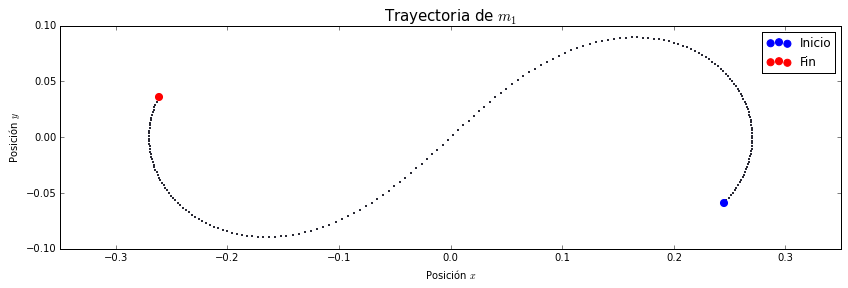

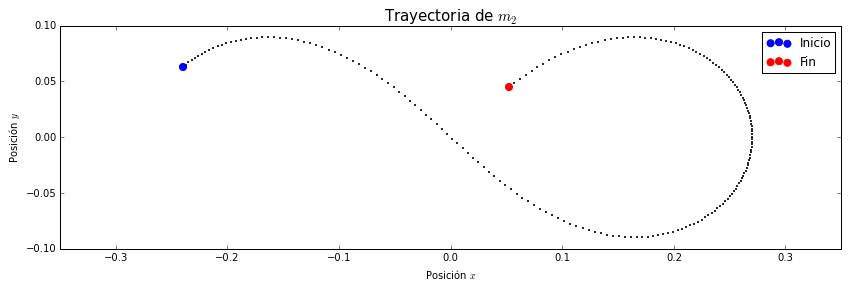

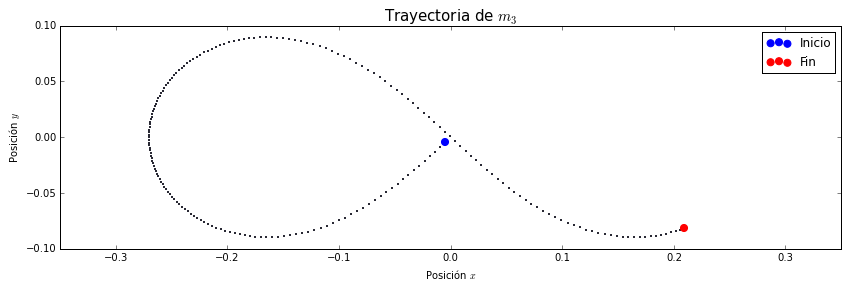

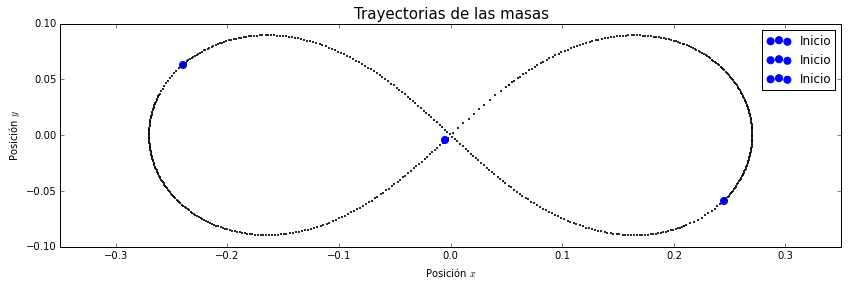

In [11]:
hist=simulacion(numIter=200,Y=Y3,tmax=0.5)
graficador(hist,masa=1)
graficador(hist,masa=2)
graficador(hist,masa=3)
graficador(hist,masa=0)

###(b) Las trayectorias son periódicas, calcule el periodo con por lo menos tres cifras significativas.

In [12]:
periodoN3 = encuentraT(Y=Y3,rangoa=0.7,rangob=0.8)
print('El periodo de las trayectorias es de aproximadamente %.10f unidades de tiempo.'%periodoN3)

El periodo de las trayectorias es de aproximadamente 0.7939393939 unidades de tiempo.


###(c) Haga una animación de las trayectorias de los cuatro cuerpos.

In [12]:
hist=simulacion(numIter=200,Y=Y3,tmax=periodoN3)
animador(hist)

###La animación se puede encontrar en el siguiente [enlace](https://raw.githubusercontent.com/diegolramirez/MC/master/Tareas/HW5/gravchorN3.gif).

#Punto 1) 4-Coreografía

###Cuatro masas bajo la influencia de su mutua fuerza de gravedad y siguientes condiciones iniciales tienen un movimiento periódico para cierto valor de a ($m_1\ =\ m_2\ =\ m_3\ =\ m_4\ =\ G\ =\ 1$). Donde $0.70 < a < 0.78$.

In [41]:
def Y4(a):
    #Defino las ecuaciones iniciales
    b = 0.384277200514
    c = 0
    d = 0.0156823005697
    e = 0.13966430504
    f = 0.352912599375
    g = 2.01155925929
    h = 1.19817066623
    i = 1.63619158614

    #Se ordena la información de cada masa y la del total en Y basados en la explicación inicial.
    r1 = np.array([b,c])
    r2 = np.array([-d,-e])
    r3 = np.array([-f,c])
    r4 = np.array([-d,e])

    v1 = np.array([c,a])
    v2 = np.array([-g,-h])
    v3 = np.array([c,i])
    v4 = np.array([g,-h])

    #Se crean los vectores que con la información inicial de las masas
    return(np.array([r1,v1,r2,v2,r3,v3,r4,v4]))

In [37]:
Y4 = Y4(a=0.70)

###(a)  Encuentre $a$ con cinco cifras significativas. Piense en una función objetivo que tenga un mínimo en la condición deseada, y cuando halla reducido el intervalo de búsqueda lo suficiente piense en otra que cambie de signo en la condición deseada.

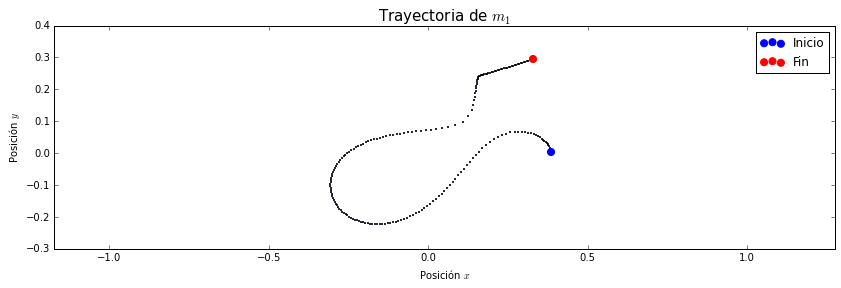

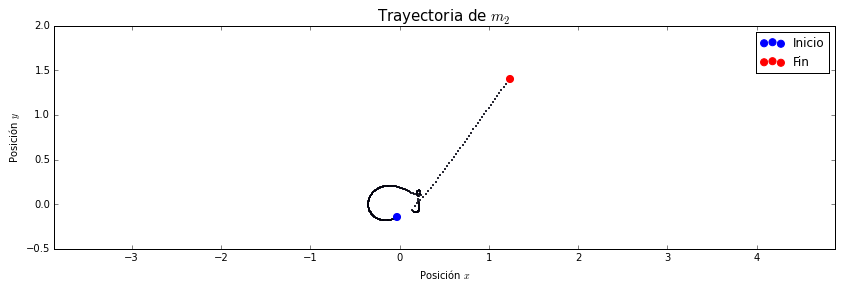

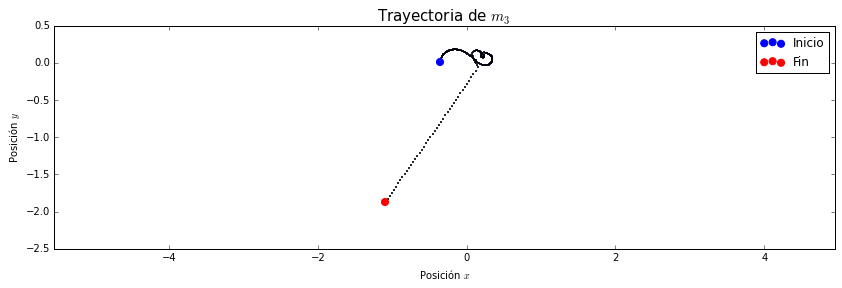

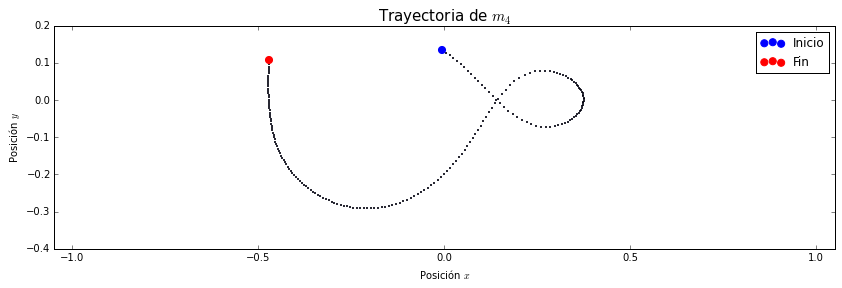

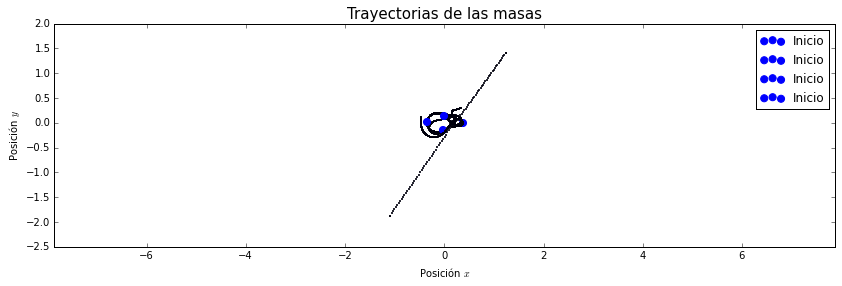

In [38]:
hist=simulacion(numIter=200,Y=Y4,tmax=1)
graficador(hist,masa=1)
graficador(hist,masa=2)
graficador(hist,masa=3)
graficador(hist,masa=4)
graficador(hist,masa=0)

In [39]:
a = afinder(Y4,iteraciones=10)
print('El a necesario para quelas trayectorias sean periódicas es de aproximadamente %.10f.'%a)

Iteración número 1
Iteración número 2
Iteración número 3
Iteración número 4
Terminé y lo encontré :)
El a necesario para quelas trayectorias sean periódicas es de aproximadamente 0.7599936000.


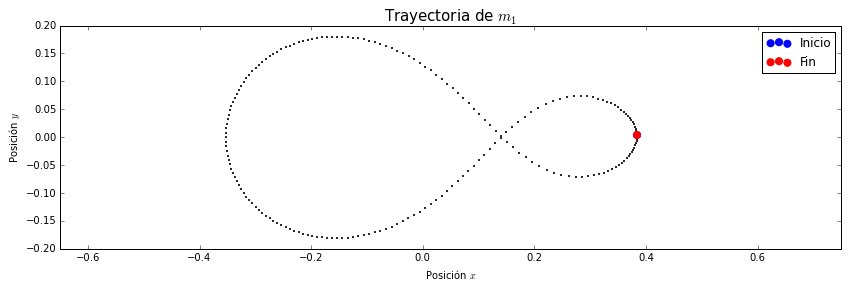

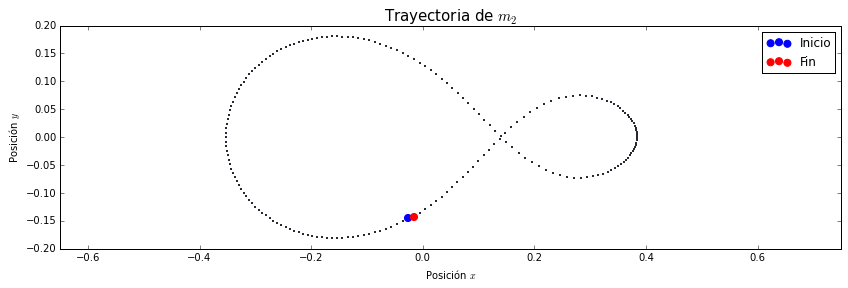

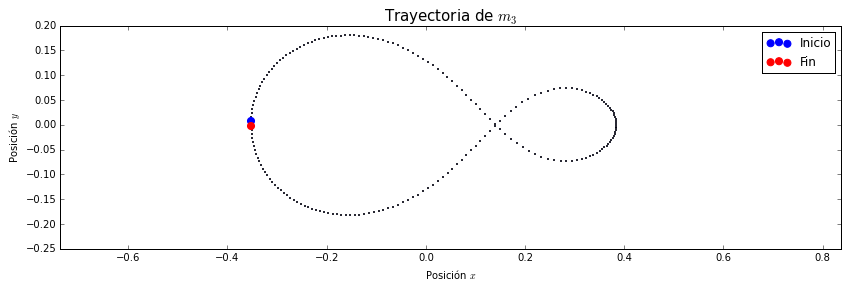

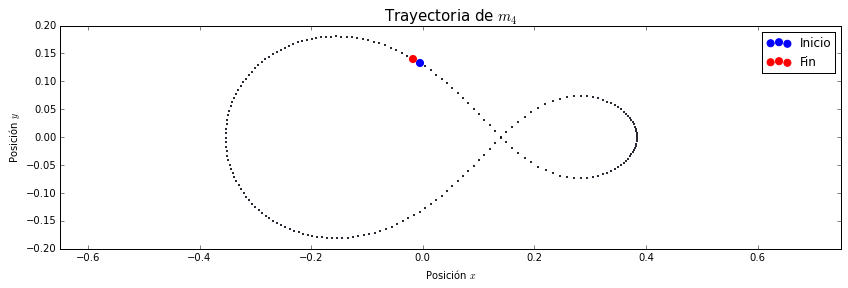

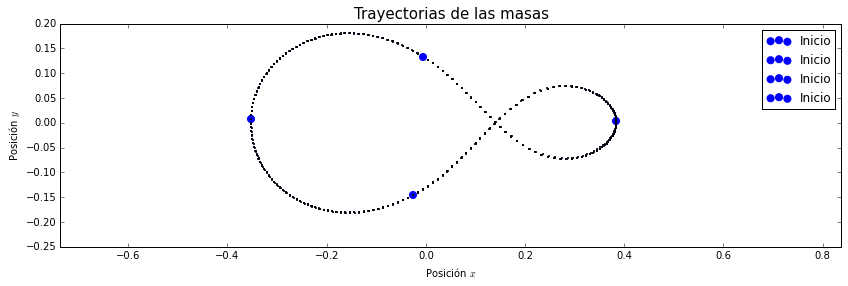

In [42]:
Y4nuevo = Y4(a=a)
hist=simulacion(numIter=200,Y=Y4nuevo,tmax=1)
graficador(hist,masa=1)
graficador(hist,masa=2)
graficador(hist,masa=3)
graficador(hist,masa=4)
graficador(hist,masa=0)

###(b) Con el valor de $a$ encontrado haga una gráfica con la energía cinética, la energía potencial y la energía total del sistema en función del tiempo.

In [ ]:
#por hacer

###(c) Haga una animación de las trayectorias de los cuatro cuerpos.

In [22]:
animador(hist)

###La animación se puede encontrar en el siguiente [enlace](https://raw.githubusercontent.com/diegolramirez/MC/master/Tareas/HW5/gravchorN4.gif).